In [1]:
import pandas as pd
import numpy as np
import datetime
import os
from IPython.display import display

from MyTransformers import *
from sklearn.model_selection import train_test_split

#%config Completer.use_jedi = False
%matplotlib inline  

In [2]:
daily_data_path = "Data/London/daily_dataset/daily_dataset/"
daily_weather_path = 'Data/London/weather_daily_darksky.csv'
holiday_data_path = 'Data/London/uk_bank_holidays.csv'
house_info_data_path = 'Data/London/informations_households.csv'

hhour_data_path = "Data/London/halfhourly_dataset/halfhourly_dataset/"
hourly_weather_path = 'Data/London/weather_hourly_darksky.csv'


f_energy_all_name = "energy_all.csv"
f_energy_hh_all_name = "energy_hh_all.csv"

f_data_path = "PrepedData/"
f_test_path = f_data_path + "Test/"
f_energy_clean_name = "energy_clean"

f_energy_avg_name = f_data_path + "energy_avg"
f_energy_avg_hhourly_name = "energy_avg_hhourly"

f_holiday_data_sufix = "_hdata"

#tmp_path = "tmp/"
#if not os.path.exists(tmp_path):
#    os.mkdir(tmp_path)

## Load blocked data and create 1 file

In [52]:
# Load Daily Data from bolcks and save to file
fout= open(f_data_path + f_energy_all_name,"w")

dtypes = {'LCLid':'str', 'day':'str', 'energy_median':'float', 'energy_mean':'float', 'energy_max':'float',
          'energy_count':'int', 'energy_std':'float', 'energy_sum':'float', 'energy_min':'float'}

for num in range(0,112):
    df = pd.read_csv(f"{daily_data_path}block_{str(num)}.csv", dtype=dtypes, parse_dates=['day'] )
    df.rename(columns = {"day": "date"}, inplace = True)
    df = df[['LCLid','date','energy_sum']]
    df.to_csv(f_energy_all_name, mode='a', index=False, header=num==0) #Add header only once
    progres_bar(num,112)
fout.close()

In [7]:
# Load HHour Data from bolcks to RAM
#fout= open(f_data_path + f_energyh_all_name,"w")
#dtypes = {'LCLid':'str', 'tstp':'str', 'energy(kWh/hh)':'float'}
dfs = []
for num in range(0,112):
    df = pd.read_csv(f"{hhour_data_path}block_{str(num)}.csv", parse_dates=['tstp'] ,na_values=['Null'] )
    # df = pd.read_csv(f"{hhour_data_path}block_{str(num)}.csv", parse_dates=['tstp'] ,engine='pyarrow',na_values=['Null'] )
    df['energy(kWh/hh)'] =  pd.to_numeric(df['energy(kWh/hh)'], errors='coerce',downcast='float')
    #df.rename(columns = {"tstp": "date"}, inplace = True)
    dfs.append(df)
    progres_bar(num,112)
    
energy_hhour = pd.concat(dfs, ignore_index=True)
#energy_hhour['energy(kWh/hh)'] =  pd.to_numeric(energy_hhour['energy(kWh/hh)'], errors='coerce',downcast='float')
energy_hhour.info()
#fout.close()

<class 'pandas.core.frame.DataFrame'>███████████████████████████████████████████████████████████████| 99.11%%
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 3.1+ GB


In [8]:
energy_hhour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 3.1+ GB


# Load data from files

In [17]:
dtypes_in = {'LCLid':'str', 'date': 'str','energy_sum':'float', 'day': 'int8', 'month': 'int8', 'year': 'int16'}
energy = pd.read_csv(f_energy_all_name, dtype=dtypes_in)
energy.date = pd.to_datetime(energy.date,format='%Y-%m-%d').dt.date
#energy.info()

#### Daily weather

In [45]:
weather = pd.read_csv(daily_weather_path)
weather['date']=  pd.to_datetime(weather['time'], format='%Y-%m-%d').dt.date # day is given as timestamp
weather = weather[['temperatureMax','date']]
#weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
#       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
#       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
#       'temperatureLow', 'temperatureMin', 'temperatureHigh',
#       'apparentTemperatureMin', 'moonPhase','date']]
#imputer = SimpleImputer(strategy="median")
#imputer.fit(weather)
#X = imputer.transform(weather)
#weather = pd.DataFrame(X, columns=weather.columns, index=weather.index)



#### HHour Weather

In [74]:
dtypes_weatherh = {'temperature':'float32'}
weather_h = pd.read_csv(hourly_weather_path,dtype=dtypes_weatherh)
weather_h['date']=  pd.to_datetime(weather_h['time'], format='%Y-%m-%d %H:%M')
weather_h = weather_h[['temperature','date']]
weather_h = weather_h.dropna()

l = len(weather_h.index)
for i in range(1,l):
    t_avg = (weather_h.loc[i-1].temperature + weather_h.loc[i].temperature ) / 2
    date = weather_h.loc[i-1].date
    date = date.replace(minute=30)
    weather_h.loc[len(weather_h.index)] = [t_avg, date]
    
weather_h = weather_h.sort_values(['date'])

In [78]:
weather_h.to_csv(f_data_path + 'weather_hhourly_darksky.csv', mode='w', index=False, header=True) 

In [14]:
weather_h = pd.read_csv(f_data_path + 'weather_hhourly_darksky.csv',dtype={ 'temperature':'float32','date':'str'})
weather_h['date']=  pd.to_datetime(weather_h['date'], format='%Y-%m-%d %H:%M')

#### Holiday dates

In [15]:
holiday = pd.read_csv(holiday_data_path)
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date


#### Household infor Acorn index 

In [16]:
house_info = pd.read_csv(house_info_data_path)

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(house_info[['Acorn']])
house_info['Acorn_category'] = housing_cat_encoded
house_info = house_info[['LCLid', 'Acorn_category']]


# Save daily Clean data 

In [ ]:
energy_info = energy.merge(weather,on='date')
energy_info = energy_info.merge(holiday, left_on = 'date',right_on = 'Bank holidays',how = 'left')
energy_info['holiday_ind'] = np.where(energy_info['Bank holidays'].isna(),0,1)
energy_info = energy_info.merge(house_info, on = ['LCLid'])
energy_info = energy_info[['LCLid', 'date','energy_sum', 'temperatureMax', 'holiday_ind', 'Acorn_category']]

In [31]:
households = energy_info.groupby('LCLid').count()
print(households['date'].median(), households['energy_sum'].mean())
print(households.describe())

h_names_small_data_size = households[households['energy_sum'] < 600].index
s = set(h_names_small_data_size)
b = [e not in s for e in energy_info['LCLid']]
energy_clean = energy_info[b]
energy_clean = energy_clean.reset_index()

#weather_energy_clean =  energy_clean.merge(weather,on='date')
#weather_energy_clean = weather_energy_clean[['LCLid','energy_sum', 'day', 'month','temperatureMax']]

650.0 629.9475386273805
              date   energy_sum  temperatureMax  holiday_ind  Acorn_category
count  5566.000000  5566.000000     5566.000000  5566.000000     5566.000000
mean    629.952928   629.947539      629.952928   629.952928      629.952928
std     112.066799   112.088978      112.066799   112.066799      112.066799
min       1.000000     0.000000        1.000000     1.000000        1.000000
25%     599.000000   599.000000      599.000000   599.000000      599.000000
50%     650.000000   650.000000      650.000000   650.000000      650.000000
75%     683.000000   683.000000      683.000000   683.000000      683.000000
max     829.000000   829.000000      829.000000   829.000000      829.000000


In [38]:
energy_clean.to_csv(f_data_path + f_energy_clean_name+"_all.csv", mode='w', index=False, header=True) 

### Create test train splits 

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(energy_clean, energy_clean['Acorn_category']):
    strat_train_set = energy_clean.loc[train_index]
    strat_test_set = energy_clean.loc[test_index]

In [39]:
strat_train_set.to_csv(f_data_path + f_energy_clean_name+"_strat.csv", mode='w', index=False, header=True) 
strat_test_set.to_csv(f_test_path + f_energy_clean_name+"_strat.csv", mode='w', index=False, header=True) 

In [40]:
e_clean_train_set, e_clean_test_set = train_test_split(energy_clean, test_size=0.2, random_state=42)

In [41]:
e_clean_train_set.to_csv(f_data_path + f_energy_clean_name+".csv", mode='w', index=False, header=True) 
e_clean_test_set.to_csv(f_test_path + f_energy_clean_name+".csv", mode='w', index=False, header=True) 

In [81]:
test = round(house_info["Acorn_category"].value_counts() * 0.1)
#shuffle data if deemed necessery 
test_ids = []
for idx , r in house_info.iterrows():
    if test[r.Acorn_category] > 0 :
        test_ids.append(r.LCLid)
        test[r.Acorn_category] -= 1

test_ids = set(test_ids)
test_mask = [house_id in test_ids for house_id in energy_clean['LCLid']]
train_mask = np.invert(test_mask)
test_per_house_set = energy_clean[test_mask]
train_per_house_set = energy_clean[train_mask]

In [84]:
train_per_house_set.to_csv(f_data_path + f_energy_clean_name+"_per_house.csv", mode='w', index=False, header=True) 
test_per_house_set.to_csv(f_test_path + f_energy_clean_name+"_per_house.csv", mode='w', index=False, header=True) 

# Save Half hour Clean data

## Transform

In [ ]:
energy_info_hh = energy_hhour.merge(weather_h,left_on='tstp',right_on='date',how='left')
# energy_info_hh.drop(['tstp'],axis=1,inplace=True)
print("added weather")
energy_info_hh['holiday_ind'] = np.where(energy_info_hh['date'].dt.date.isin( holiday['Bank holidays']),1,0)
print("added holiday")
energy_info_hh = energy_info_hh.merge(house_info, on = ['LCLid'],how='left')
print("added acorn cat")
# energy_info_hh = energy_info_hh[['LCLid', 'date','energy(kWh/hh)', 'temperature', 'holiday_ind', 'Acorn_category_x']]
# energy_info_hh.rename(columns={'energy(kWh/hh)':'energy','Acorn_category_x': 'Acorn_category'},inplace=True)
energy_info_hh = energy_info_hh[['LCLid', 'date','energy(kWh/hh)', 'temperature', 'holiday_ind', 'Acorn_category']]
energy_info_hh.rename(columns={'energy(kWh/hh)':'energy'},inplace=True)
energy_hhour = None # Drop database for RAM sake

In [123]:
households = energy_info_hh.groupby('LCLid').count()
print(households['date'].median(), households['energy'].mean())
print(households.describe())


31079.0 30149.383399209488
               date        energy   temperature   holiday_ind  Acorn_category
count   5566.000000   5566.000000   5566.000000   5566.000000     5566.000000
mean   30144.717391  30149.383399  30144.717391  30150.381064    30150.381064
std     5369.865408   5370.625648   5369.865408   5370.629816     5370.629816
min        0.000000      0.000000      0.000000      1.000000        1.000000
25%    28674.000000  28679.000000  28674.000000  28680.000000    28680.000000
50%    31079.000000  31084.000000  31079.000000  31085.000000    31085.000000
75%    32707.000000  32712.000000  32707.000000  32713.000000    32713.000000
max    39719.000000  39724.000000  39719.000000  39725.000000    39725.000000


In [125]:

h_names_small_data_size = households[households['energy'] < 20000].index
s = set(h_names_small_data_size)
b = ~energy_info_hh['LCLid'].isin(s)
energy_hh_clean = energy_info_hh[b]
del b
energy_hh_clean.reset_index(inplace=True,drop=True)
del energy_info_hh # For RAM sake


249

In [145]:
energy_hh_clean['dayPrecent'] = -np.sin(energy_hh_clean['date'].dt.hour )/24 + (energy_hh_clean['date'].dt.minute )/(24*60)
energy_hh_clean['yearPrecent'] = np.cos(energy_hh_clean['date'].dt.month - 1)/12 + (energy_hh_clean['date'].dt.day - 1)/(12*30)

c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\jurek\.pyenv\pyenv-win\versions\3.7.4-amd64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [162]:
energy_hh_clean = energy_hh_clean.astype({'holiday_ind':'bool','Acorn_category':'uint8','dayPrecent':'f2','yearPrecent':'f2','temperature': 'f4','energy':'f4'})
energy_hh_clean['id'] = [int(id[5:]) for id in energy_hh_clean['LCLid']]
energy_hh_clean = energy_hh_clean.astype({'id':'uint16'})
energy_hh_clean.drop(['LCLid'],axis=1,inplace=True)
energy_hh_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164349109 entries, 0 to 164349108
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   date            datetime64[ns]
 2   energy          float32       
 3   temperature     float32       
 4   holiday_ind     bool          
 5   Acorn_category  uint8         
 6   dayPrecent      float16       
 7   yearPrecent     float16       
dtypes: bool(1), datetime64[ns](1), float16(2), float32(2), object(1), uint8(1)
memory usage: 4.6+ GB


In [195]:
energy_hh_clean = energy_hh_clean.sort_values(by=['id','date'])
energy_hh_clean.dropna(inplace=True)

In [ ]:
energy_hh_clean.drop(['date'],axis=1,inplace=True)

In [288]:
energy_hh_clean.reset_index(drop=True,inplace=True)
days_back = 4
ind = np.arange(days_back)
id = energy_hh_clean['id']
for i in range(1,len(id)):
    if id[i] != id[i - 1]: ind = np.append(ind, np.arange(i,i+days_back))


In [78]:
g = energy_hh_clean.groupby('id')

In [87]:
ind = np.array([])

for ii,i in enumerate(ids):
    s = g.get_group(i).index[0]
    ind = np.append(ind, np.arange(s,s+4))
    progres_bar(ii+1, len(ids))


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [39]:
# df = pd.DataFrame(ind)
# df.to_csv(f_data_path + "ind.csv", mode='w', index=False, header=True) 
ind = pd.read_csv(f_data_path + "ind.csv") 

In [3]:
# energy_hh_clean.to_feather(f_data_path + "energy_hh_clean.feather")
energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean.feather")

In [4]:
energy_hh_clean

,date,energy,temperature,holiday_ind,Acorn_category,dayPrecent,yearPrecent,id,energy_0,energy_1
0,2012-10-12 00:30:00,0.000,13.350000,False,1,0.020828,0.866699,2,0.000,0.0
1,2012-10-12 01:00:00,0.000,13.090000,False,1,0.041656,0.866699,2,0.000,0.0
2,2012-10-12 01:30:00,0.000,12.815001,False,1,0.062500,0.866699,2,0.000,0.0
3,2012-10-12 02:00:00,0.000,12.540000,False,1,0.083313,0.866699,2,0.000,0.0
4,2012-10-12 02:30:00,0.000,12.240000,False,1,0.104187,0.866699,2,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
164317923,2014-02-27 22:00:00,0.173,4.100000,False,17,0.916504,0.241699,5567,0.076,0.0
164317924,2014-02-27 22:30:00,0.205,4.015000,False,17,0.937500,0.241699,5567,0.173,0.0
164317925,2014-02-27 23:00:00,0.221,3.930000,False,17,0.958496,0.241699,5567,0.205,0.0
164317926,2014-02-27 23:30:00,0.222,7.465000,False,17,0.979004,0.241699,5567,0.221,0.0


In [56]:
# yearPercent fix
energy_hh_clean['yearPrecent'] = (((energy_hh_clean['yearPrecent'] - 1/12) * 12/11) - 1/(12*30) ) * (12*30)/((12*30) -1)

In [66]:
days_back = 4;data_tag='energy'
index = 3
#for index in range(0, days_back):
energy_hh_clean[f'{data_tag}_{index}'] = 0.0 
energy_hh_clean.loc[days_back:len(energy_hh_clean),f'{data_tag}_{index}'] =  energy_hh_clean[days_back-index -1:len(energy_hh_clean)-index -1][data_tag].values
energy_hh_clean = energy_hh_clean.astype({f'{data_tag}_{index}':'f2'})

In [68]:
energy_hh_clean.to_feather(f_data_path + "temp.feather")

In [26]:
energy_hh_clean.drop(['id'],axis=1,inplace=True)

In [43]:
print(energy_hh_clean.memory_usage())
energy_hh_clean.info()

Index                    128
energy             657271712
temperature        657271712
holiday_ind        164317928
Acorn_category     164317928
dayPrecent         328635856
yearPrecent        328635856
pastET            1314543424
energy_0           328635856
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164317928 entries, 0 to 164317927
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   energy          float32
 1   temperature     float32
 2   holiday_ind     bool   
 3   Acorn_category  uint8  
 4   dayPrecent      float16
 5   yearPrecent     float16
 6   pastET          float64
 7   energy_0        float16
dtypes: bool(1), float16(3), float32(2), float64(1), uint8(1)
memory usage: 3.7 GB


In [74]:
ind = ind.flatten()

AttributeError: 'DataFrame' object has no attribute 'flatten'

In [80]:
ind = ind.values.reshape(-1)

In [90]:
energy_hh_clean.drop(index=ind, inplace=True)
energy_hh_clean.reset_index(drop=True,inplace=True)

In [4]:
#energy_hh_clean.to_feather(f_data_path + "energy_hh_clean_all_pastET_fix_perc_id.feather")
energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean_all_pastET_fix_perc_id.feather")

In [6]:
energy_hh_clean.drop('id',axis=1,inplace=True)

In [7]:
energy_hh_clean['dayPrecent'] = -np.sin(energy_hh_clean['dayPrecent'])
energy_hh_clean['yearPrecent'] = np.cos(energy_hh_clean['yearPrecent'])

#### Add past day energy from the same time 

In [4]:
energy_hh_clean.drop(['energy_0','energy_1'],axis = 1, inplace=True) 

In [5]:
ids = energy_hh_clean['id'].unique()
g = energy_hh_clean.groupby('id')
_ = g.get_group(2)

In [6]:
pastET = np.empty(len(energy_hh_clean),dtype='f2')
ball = np.empty(len(energy_hh_clean))
ind = 0
for i, id in enumerate(ids):
    # home = energy_hh_clean[energy_hh_clean['id'] == id].copy()
    home = g.get_group(id).copy()
    p = home['date'] - pd.to_timedelta(1, unit='d')
    b = p.isin(home['date'])
    ball[ind:ind+len(b)] = b
    home['pastET'] = 0.0
    home.loc[b,'pastET'] =  home.loc[home['date'].isin(p),'energy'].values.copy()
    pastET[ind:ind+len(home)] = home['pastET'].values.copy()
    ind += len(home)
    progres_bar(i + 1,len(ids))

energy_hh_clean['pastET'] = pastET
del p,b,home

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [7]:
df = pd.DataFrame(ball.astype('?'))

In [8]:
del pastET,ball

In [42]:
np.sum(df)

0    163738062
dtype: int64

In [33]:
l = 2162078
lenData = len(energy_hh_clean)
progres_bar(0,lenData)
x = [] 
for i in range(0,lenData,l): ## Looping through batches
    a = energy_hh_clean[i:i+l]
    x.append( a[df[i:i+l].values])
    progres_bar(i+l,lenData)

|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [36]:
energy_hh_clean = pd.concat(x, ignore_index=True)

In [49]:
energy_hh_clean

,date,energy,temperature,holiday_ind,Acorn_category,dayPrecent,yearPrecent,id,pastET
0,2012-10-13 00:30:00,0.269,8.525,False,1,0.020828,0.869629,2,0.000
1,2012-10-13 01:00:00,0.275,8.270,False,1,0.041656,0.869629,2,0.000
2,2012-10-13 01:30:00,0.256,8.070,False,1,0.062500,0.869629,2,0.000
3,2012-10-13 02:00:00,0.211,7.870,False,1,0.083313,0.869629,2,0.000
4,2012-10-13 02:30:00,0.136,7.880,False,1,0.104187,0.869629,2,0.000
...,...,...,...,...,...,...,...,...,...
163738057,2014-02-27 22:00:00,0.173,4.100,False,17,0.916504,0.241699,5567,0.217
163738058,2014-02-27 22:30:00,0.205,4.015,False,17,0.937500,0.241699,5567,0.209
163738059,2014-02-27 23:00:00,0.221,3.930,False,17,0.958496,0.241699,5567,0.128
163738060,2014-02-27 23:30:00,0.222,7.465,False,17,0.979004,0.241699,5567,0.051


In [72]:
# energy_hh_clean.to_feather(f_data_path + "energy_hh_clean_pastET_dropped.feather")
#energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean_pastET.feather")
x = pd.read_feather(f_data_path + "energy_hh_clean_pastET_dropped.feather")

## Split batches

In [9]:
#energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean_all.feather")
energy_hh_clean_data = energy_hh_clean.drop('energy', axis=1)
energy_hh_clean_labels = energy_hh_clean['energy'].copy()
del energy_hh_clean

In [6]:
len(energy_hh_clean_data)
#find best devisor for batching

163716794

In [10]:
# X_train, X_test, Y_train, Y_test = train_test_split(energy_hh_clean_data, energy_hh_clean_labels, train_size=0.9, random_state=123)
X_train, X_test, Y_train, Y_test = train_test_split(energy_hh_clean_data, energy_hh_clean_labels, train_size=87/97, random_state=123)
del energy_hh_clean_data
del energy_hh_clean_labels
# Data dims after train split ((147866994, 9), (16429666, 9), (147866994,), (16429666,))

## STD Scale and save X

In [14]:
s = StandardScaler()
# 97, 194, 1067, 2134, 7699, 84689,169378,746803,1493606,8214833,16429666
# train batches size = 99
# test batches size = 11
l = 1493606
lenData = len(X_train)
print("fit X Train")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    s.partial_fit(X_train[i:i+l])
    progres_bar(i+l,lenData)

lenData = len(X_test)
print("fit X Test")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    s.partial_fit(X_test[i:i+l])
    progres_bar(i+l,lenData)



fit X Train
fit X Test██████████████████████████████████████████████████████████████████████████████████████████| 99.89%


In [18]:
l = 1493606
lenData = len(X_train)
col = X_train.columns
print("transfor X Train")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    data_scaled = pd.DataFrame(s.transform(X_train[i:i+l]),columns=col)
    data_scaled.to_feather(f_data_path + f"HHData/xtrain{i//l}.feather")
    progres_bar(i+l,lenData)

lenData = len(X_test)
print("transfor X Test")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    data_scaled = pd.DataFrame(s.transform(X_test[i:i+l]),columns=col)
    data_scaled.to_feather(f_data_path + f"HHData/xtest{i//l}.feather")
    progres_bar(i+l,lenData)

transfor X Train
transfor X Test██████████████████████████████████████████████████████████████████████████████████████| 100.00%


## Batch data and save

In [9]:
len(X_train)/ 1687802, len(X_test) / 1687802, len(Y_train) / 1687802, len(Y_test)/ 1687802

(87.0, 10.0, 87.0, 10.0)

In [11]:
# l = 1493606
l = 1687802
path = f_data_path + "HHDataAll/"
lenData = len(X_train)

col = X_train.columns
print("Batch X Train")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    data = X_train[i:i+l].reset_index(drop=True)
    data.to_feather(path + f"xtrain{i//l}.feather")
    progres_bar(i+l,lenData)

#lenData = len(Y_train)
print("Batch Y train")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    ydata = Y_train[i:i+l].to_frame().reset_index(drop=True)
    ydata.to_feather(path + f"ytrain{i//l}.feather")
    progres_bar(i+l,lenData)



Batch X Train
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Batch Y train
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [12]:
l = 1687802
path = f_data_path + "HHDataAll/"

lenData = len(X_test)
print("Batch X Test")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    data = X_test[i:i+l].reset_index(drop=True)
    data.to_feather(path + f"xtest{i//l}.feather")
    progres_bar(i+l,lenData)

lenData = len(Y_test)
print("Batch Y Test")
progres_bar(0,lenData)
for i in range(0,lenData,l): ## Looping through batches
    ydata = Y_test[i:i+l].to_frame().reset_index(drop=True)
    ydata.to_feather(path + f"ytest{i//l}.feather")
    progres_bar(i+l,lenData)


Batch X Test
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%
Batch Y Test
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [220]:
energy_hh_clean.describe()

,energy,temperature,Acorn_category,dayPrecent,yearPrecent,id
count,1.643438e+08,1.643179e+08,1.643491e+08,1.643179e+08,1.643179e+08,1.643491e+08
mean,2.120399e-01,1.095281e+01,8.634995e+00,NaN,NaN,2.759542e+03
std,2.961209e-01,6.022693e+00,4.866891e+00,0.000000e+00,0.000000e+00,1.665081e+03
min,0.000000e+00,-5.640000e+00,0.000000e+00,0.000000e+00,8.612061e-02,2.000000e+00
25%,5.800000e-02,6.625000e+00,5.000000e+00,2.500000e-01,3.444824e-01,1.288000e+03
50%,1.170000e-01,1.049000e+01,6.000000e+00,5.000000e-01,6.279297e-01,2.712000e+03
75%,2.400000e-01,1.521500e+01,1.200000e+01,7.500000e-01,8.637695e-01,4.295000e+03
max,1.076100e+01,3.240000e+01,1.800000e+01,9.790039e-01,1.085938e+00,5.567000e+03


## Split household data

In [5]:
def AddTagDaysBack(data,index = 0,data_tag='energy', days_back = 4 ):
    data[f'{data_tag}_{index}'] = 0.0 
    data.loc[days_back:len(data),f'{data_tag}_{index}'] =  data[days_back-index -1:len(data)-index -1][data_tag].values
    data = data.astype({f'{data_tag}_{index}':'f2'})

In [6]:
#energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean.feather")
energy_hh_clean = pd.read_feather(f_data_path + "energy_hh_clean_all_pastET_fix_perc_id.feather")

In [8]:
def CreateHouseSampleByID(id,data=energy_hh_clean,path="HHDataId/"):
    e= data['id'] == id
    id2 = data.loc[e].reset_index(drop=True)
    id2 = id2.drop(['id'],axis=1)
    id2.to_feather(f_data_path+path+f"{id}.feather")
    # for i in range(4):
    #     AddTagDaysBack(id2,i,days_back=4)
    # id2 = id2.drop(['date','id'],axis=1)
    # id2.to_feather(f_data_path+f"TestId{id}.feather")

In [9]:
ids = energy_hh_clean['id'].unique()

In [12]:
for i,id in enumerate(ids):
    CreateHouseSampleByID(id)
    progres_bar(i+1,len(ids))


|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00%


In [8]:
CreateHouseSampleByID(2)
CreateHouseSampleByID(3)
CreateHouseSampleByID(69)
CreateHouseSampleByID(420)
CreateHouseSampleByID(100)
CreateHouseSampleByID(1000)

: 

# Save daily AVG data 

In [14]:
housecount = energy.groupby('date')[['LCLid']].nunique()
energy_avg = energy.groupby('date')[['energy_sum']].sum()
energy_avg = energy_avg.merge(housecount, on = ['date'])
energy_avg = energy_avg.reset_index()
energy_avg['avg_energy'] =  energy_avg['energy_sum']/energy_avg['LCLid']

energy_avg['day'] = [d.day for d in energy_avg['date']]
energy_avg['month'] = [d.month for d in energy_avg['date']]
energy_avg['year'] = [d.year for d in energy_avg['date']]

weather_energy_avg =  energy_avg.merge(weather,on='date')
weather_energy_avg = weather_energy_avg.merge(holiday, left_on = 'date',right_on = 'Bank holidays',how = 'left')
weather_energy_avg['holiday_ind'] = np.where(weather_energy_avg['Bank holidays'].isna(),0,1)
weather_energy_avg = weather_energy_avg[['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind']]

In [8]:
weather_energy_avg.to_csv("energy_avg_all.csv", mode='w', index=False, header=True) 

In [16]:
weather_energy_avg.to_csv(f_energy_avg_name+f_holiday_data_sufix+".csv", mode='w', index=False, header=True) 

In [17]:
we_avg_train_set, we_avg_test_set = train_test_split(weather_energy_avg, test_size=0.2, random_state=42)

In [18]:
we_avg_train_set.to_csv(f_energy_avg_name+"_train.csv", mode='w', index=False, header=True) 
we_avg_test_set.to_csv(f_energy_avg_name+"_test.csv", mode='w', index=False, header=True) 

# Save HHourly AVG data

In [ ]:
housecount = energy_hh_clean.groupby('date')[['LCLid']].nunique()
energy_avg = energy_hhour.groupby('date')[['energy(kWh/hh)']].sum()
energy_avg = energy_avg.merge(housecount, on = ['date'])
energy_avg = energy_avg.reset_index()
energy_avg['avg_energy'] =  energy_avg['energy(kWh/hh)']/energy_avg['LCLid']

In [ ]:
energy_avg

In [33]:
energy_avg = energy_avg.merge(g[['temperature']].to_Series(), on=['date']).reset_index(drop=True)

AttributeError: 'DataFrameGroupBy' object has no attribute 'to_Series'

In [43]:
energy_avg

,date,energy
0,2011-11-23 09:00:00,0.284500
1,2011-11-23 09:30:00,0.280500
2,2011-11-23 10:00:00,0.153333
3,2011-11-23 10:30:00,0.098000
4,2011-11-23 11:00:00,0.110286
...,...,...
39717,2014-02-27 22:00:00,0.300075
39718,2014-02-27 22:30:00,0.285482
39719,2014-02-27 23:00:00,0.252565
39720,2014-02-27 23:30:00,0.215409


In [42]:
energy_avg = energy_hhour.groupby('tstp')[['energy(kWh/hh)']].mean().reset_index()

# housecount = energy_hhour.groupby('tstp')[['LCLid']].nunique()
# energy_avg = energy_hhour.groupby('tstp')[['energy(kWh/hh)']].sum()
# energy_avg = energy_avg.merge(housecount, on = ['tstp'])
# energy_avg = energy_avg.reset_index()
# energy_avg['avg_energy'] =  energy_avg['energy(kWh/hh)']/energy_avg['LCLid']


In [101]:
print(min(weather_h['date']),max(weather_h['date']))
print(min(energy_avg_plus['tstp']),max(energy_avg_plus['tstp']))

2011-11-01 00:00:00 2014-03-31 22:30:00
2011-11-23 09:00:00 2014-02-28 00:00:00


In [114]:
energy_avg['minute'] = [d.minute for d in energy_avg['tstp']]
energy_avg['hour'] = [d.hour for d in energy_avg['tstp']]
energy_avg['day'] = [d.day for d in energy_avg['tstp']]
energy_avg['month'] = [d.month for d in energy_avg['tstp']]
energy_avg['year'] = [d.year for d in energy_avg['tstp']]

energy_avg_plus = energy_avg.merge(weather_h, left_on = 'tstp',right_on = 'date', how = 'left')
energy_avg_plus = energy_avg_plus.dropna(subset=['temperature'])

energy_avg_plus['date'] = energy_avg_plus['date'].dt.date
energy_avg_plus = energy_avg_plus.merge(holiday, left_on = 'date',right_on = 'Bank holidays',how = 'left')
energy_avg_plus['holiday_ind'] = np.where(energy_avg_plus['Bank holidays'].isna(),0,1)

energy_avg_plus = energy_avg_plus[['avg_energy', 'minute', 'hour','day', 'month', 'year', 'temperature', 'holiday_ind']]

In [119]:
energy_avg_plus.to_csv(f_data_path + f_energy_avg_hhourly_name+"_all.csv", mode='w', index=False, header=True) 

In [117]:
energy_avg_plus['holiday_ind'].value_counts()

0    38858
1      864
Name: holiday_ind, dtype: int64

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline_avg = Pipeline([
       # ('imputer', SimpleImputer(strategy="median")),
        ('avg_tr', AverageTransformer()),
        ('discreat_date_tr', DiscreatDate()),
        ('weather_tr', WeatherDataMerge(weather=weather)),
        ('holiday_tr', HolidayDataMerge(holiday=holiday)),
        ('select_tr', Select(features=['avg_energy', 'day', 'month', 'temperatureMax', 'holiday_ind'])),
        ('std_scaler', StandardScaler()),
    ])

energy_tr = pipeline_avg.fit_transform(energy)

### Print test example data

In [9]:
import matplotlib.pyplot as plt
path = r'E:\Programing\Magister\Load Prediction\PrepedData\HHDataId\\'

df = pd.read_feather(path + "69.feather")

In [238]:
path = r'E:\Programing\Magister\Load Prediction\Data\London\daily_dataset\daily_dataset\\'
#path = r'E:\Programing\Magister\Load Prediction\Data\London\halfhourly_dataset\halfhourly_dataset\\'
df = pd.read_csv(path + 'block_69.csv')
df['LCLid'].unique()

array(['MAC000340', 'MAC000341', 'MAC000394', 'MAC000452', 'MAC000498',
       'MAC000533', 'MAC000547', 'MAC000784', 'MAC000998', 'MAC001261',
       'MAC001288', 'MAC001295', 'MAC001302', 'MAC001306', 'MAC001317',
       'MAC001356', 'MAC001679', 'MAC001719', 'MAC001749', 'MAC002004',
       'MAC002020', 'MAC002776', 'MAC002780', 'MAC003085', 'MAC003318',
       'MAC003324', 'MAC003327', 'MAC003784', 'MAC003794', 'MAC003795',
       'MAC003801', 'MAC003806', 'MAC003815', 'MAC003839', 'MAC003842',
       'MAC003855', 'MAC003857', 'MAC003859', 'MAC003867', 'MAC003873',
       'MAC003875', 'MAC003878', 'MAC003879', 'MAC003882', 'MAC003888',
       'MAC003896', 'MAC003917', 'MAC003925', 'MAC003926', 'MAC003930'],
      dtype=object)

C:\Users\Jakub\AppData\Local\Temp\ipykernel_11028\1506323504.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(data['energy_sum'][offset:offset + plotRange].to_list() )


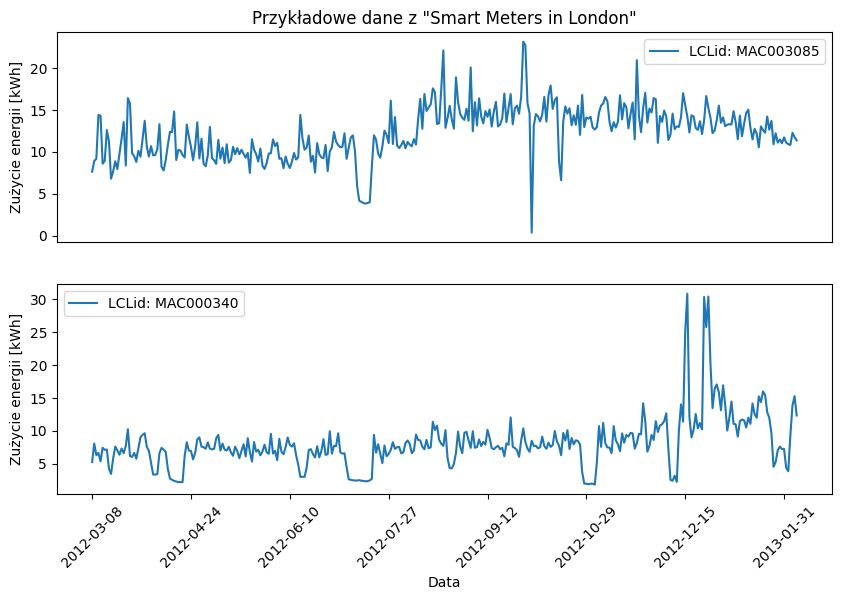

In [245]:
import matplotlib.pyplot as plt
path = r'E:\Programing\Magister\Load Prediction\Data\London\daily_dataset\daily_dataset\\'
df = pd.read_csv(path + 'block_69.csv')
offset = 0
plotRange = 7*12*4
id = 'MAC003085'
id2 = 'MAC000340'
ticksPer = 47
#data = df[df['LCLid'] == id].sort_values(['day'])


f, (ax1, ax2) = plt.subplots(2, 1)
f.set_size_inches(10,6)

perc = 0.00
yoffset = 0.07

data = df[df['LCLid'] == id].sort_values(['day'])
ax1.plot(data['energy_sum'][offset:offset + plotRange].to_list() )
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * perc + yoffset,
               box.width, box.height * (1 - perc)])

data = df[df['LCLid'] == id2].sort_values(['day'])
ax2.plot(data['energy_sum'][offset:offset + plotRange].to_list() )
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * perc * 2.5 + yoffset,
               box.width, box.height * (1 - perc)])

#plt.plot(data['energy(kWh/hh)'].to_list() )
ax1.set_xticks([])
ax2.set_xticks(rotation=45, ticks=range(0,plotRange,ticksPer),labels=data['day'][offset:offset + plotRange:ticksPer])
ax2.set_xlabel("Data")
ax1.set_ylabel('Zużycie energii [kWh]')
ax2.set_ylabel('Zużycie energii [kWh]')
ax1.set_title('Przykładowe dane z "Smart Meters in London"')
ax1.legend([f'LCLid: {id}'])
ax2.legend([f'LCLid: {id2}'])
plt.savefig(r"E:\Programing\Magister\Load Prediction\Results\Plots\dataAnalisys\przykladLondon.png")

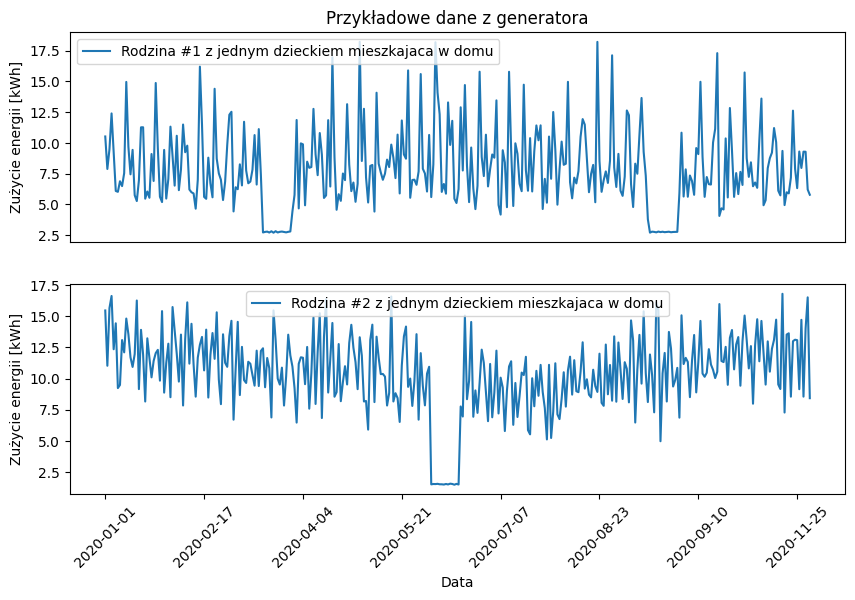

In [252]:

f, (ax1, ax2) = plt.subplots(2, 1)
f.set_size_inches(10,6)

perc = 0.00
yoffset = 0.07

dflpg = pd.read_feather(r"E:\Programing\Magister\Load Prediction\PrepedData\LPG-Profile-0.feather")
data = dflpg['energy'].values.reshape(-1,60*24)
data = data.sum(axis=1,keepdims=True)

dates = dflpg['date'].dt.strftime("%Y-%m-%d").unique()

ax1.plot(data[:plotRange])
box = ax1.get_position()
ax1.set_position([box.x0, box.y0 + box.height * perc + yoffset,
               box.width, box.height * (1 - perc)])

dflpg = pd.read_feather(r"E:\Programing\Magister\Load Prediction\PrepedData\LPG-Profile-1.feather")
data = dflpg['energy'].values.reshape(-1,60*24).sum(axis=1,keepdims=True)
ax2.plot(data[:plotRange] )
box = ax2.get_position()
ax2.set_position([box.x0, box.y0 + box.height * perc * 2.5 + yoffset,
               box.width, box.height * (1 - perc)])

#plt.plot(data['energy(kWh/hh)'].to_list() )
ax1.set_xticks([])
ax2.set_xticks(rotation=45, ticks=range(0,plotRange,ticksPer),labels=dates[:plotRange:ticksPer])
ax2.set_xlabel("Data")
ax1.set_ylabel('Zużycie energii [kWh]')
ax2.set_ylabel('Zużycie energii [kWh]')
ax1.set_title('Przykładowe dane z generatora')
ax1.legend([f'Rodzina #1 z jednym dzieckiem mieszkajaca w domu'])
ax2.legend([f'Rodzina #2 z jednym dzieckiem mieszkajaca w domu'])
plt.savefig(r"E:\Programing\Magister\Load Prediction\Results\Plots\dataAnalisys\przykladLPG.png")

In [263]:
data = dflpg['energy'].values.reshape(-1,60*24).sum(axis=1,keepdims=True)

In [270]:
np.mean(data)

10.730973538041022